In [1]:
using ExpFamilyPCA
using CompressedBeliefMDPs
using Random
using Plots
using Statistics

Random.seed!(1)

TaskLocalRNG()

In [2]:
function kl_div(p, q; ϵ=eps())
    return sum(@. p * log((p + ϵ) / (q + ϵ)))
end

function to_probability(matrix::AbstractMatrix)
    matrix = clamp.(matrix, 0, 1)
    prob_matrix = matrix ./ sum(matrix, dims=2)
    return prob_matrix
end

function calc_kl(
    epca::EPCA, 
    X::AbstractMatrix{T}
) where T<:Real
    V = epca.V
    A = ExpFamilyPCA.fit!(epca, X; maxiter=100, verbose=true, steps_per_print=10)
    X_recon = decompress(epca, A)
    Q = to_probability(X_recon)
    divergences = []
    for (p, q) in zip(eachrow(X), eachrow(Q))
        kl = kl_div(p, q)
        push!(divergences, kl)
    end
    result = mean(divergences)  # Return the mean KL divergence
    @show result
    return result
end

calc_kl (generic function with 1 method)

In [3]:
n_corridors = 2
corridor_length = 100
maze = CircularMaze(n_corridors, corridor_length)
sampler = PolicySampler(maze, n=200)
raw_beliefs = sampler(maze)
beliefs = make_numerical(raw_beliefs, maze)

n, indim = size(beliefs)

outdims = 1:10

kl_divs_poisson_epca = []
kl_divs_gaussian_epca = []

for outdim in outdims
    @show outdim
    push!(kl_divs_poisson_epca, calc_kl(PoissonEPCA(indim, outdim), beliefs))
    push!(kl_divs_gaussian_epca, calc_kl(GaussianEPCA(indim, outdim), beliefs))
end

outdim = 1
Iteration: 1/100 | Loss: 2.9092554259788823
Loss converged early. Stopping iteration.
result = 0.5471631685533801
Iteration: 1/100 | Loss: 0.003262807887809232
Iteration: 10/100 | Loss: 0.001992085020447911
Loss converged early. Stopping iteration.
result = 9.942367552747232
outdim = 2
Iteration: 1/100 | Loss: 2.905080723348808
Iteration: 10/100 | Loss: 2.656899037309395
Iteration: 20/100 | Loss: 2.656861907960781
Iteration: 30/100 | Loss: 2.6568468545853166
Iteration: 40/100 | Loss: 2.6568414934278937
Iteration: 50/100 | Loss: 2.6568383681017846
Iteration: 60/100 | Loss: 2.656836250567437
Iteration: 70/100 | Loss: 2.6568344752853332
Iteration: 80/100 | Loss: 2.656833054358214
Iteration: 90/100 | Loss: 2.656831886367816
Iteration: 100/100 | Loss: 2.6568306827487453
result = 0.0019628746362562286
Iteration: 1/100 | Loss: 0.003127312925089184
Iteration: 10/100 | Loss: 0.000780747311220163
Loss converged early. Stopping iteration.
result = 0.5203241611487013
outdim = 3
Iteratio

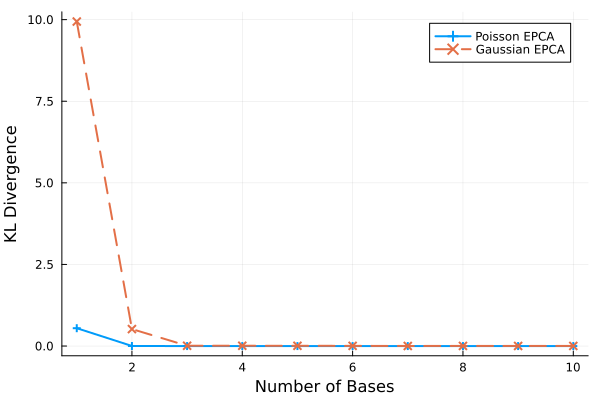

In [4]:
plot(
    outdims, 
    kl_divs_poisson_epca, 
    label="Poisson EPCA", 
    marker=:cross, 
    linestyle=:solid, 
    lw=2
)
plot!(
    outdims, 
    kl_divs_gaussian_epca, 
    label="Gaussian EPCA",
    marker=:x,
    linestyle=:dash,
    lw=2
)
xlabel!("Number of Bases")
ylabel!("KL Divergence")